<a href="https://colab.research.google.com/github/kevinracso/01Tarea/blob/master/DeepHits_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Permite importar archivos desde Google Drive

In [203]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Opciones de ejecución

In [0]:
"Modificar aqui las opciones de ejecucion"

crop_21 = True # True si se desea trabajar con el crop (suele dar mejores resultados)
rotations = True # True si se desea incluir rotaciones al modelo 
iteraciones = 1 # Entero, número de veces que se entrenará la red (con reinicios)
dense_concat = True

# Importar librerías

In [0]:
import numpy as np
import pandas as pd
import matplotlib
#%matplotlib inline
import matplotlib.pyplot as plt

import matplotlib.cm as cm
from skimage import io, img_as_float
import scipy.interpolate as itp

import tensorflow as tf

import random

In [0]:
from __future__ import print_function
from time import time

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning) # Comando para ignorar los warnings


import keras  # Importando la libreria keras
from keras.models import Sequential  
from keras.layers import Dense, Dropout, Flatten # Comandos de keras que importan las capas dense, dropout y flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D # Comandos de keras que importan las capas convolucionales y maxpooling2D
from keras.layers import Lambda
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import plot_model
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

In [207]:
keras.__version__

'2.2.5'

# Cargar base de datos 

In [0]:
# Cargando base de datos Alerce.
data = pd.read_pickle('/content/drive/My Drive/Supernova/ALERCE_stamps.pkl') # Base de datos original
#data = pd.read_pickle('/content/drive/My Drive/Supernova/ALERCE_stamps_1k.pkl') # Base de datos reducida

In [0]:
imgs = data['images'] # Lista de 31727 imagenes
labels = data['labels'] # Lista de 31727 labels

img_0 = imgs[0] # Primera imagen de imgs, ndarray 63x63, 3 canales
label_0 = labels[0] # Primer label, entero

clases = {0 : "AGN", 1 : "SN", 2 : "VS", 3 : "AST", 4 : "bogus"} # diccionario con las clases

In [210]:
np.shape(imgs)

(31727,)

# Desechar imágenes no cuadradas

In [211]:
shap_def = (63, 63, 3) # Estructura correcta de imagenes, cuadradas, 3 canales

img_sq = [] # Inicializar lista vacia para almacenar imagenes que tienen
            # estructura correcta
label_sq = [] # Inicializar lista vacia para almacenar labels de imagenes que
              # tienen estructura correcta
    
for j in list(range(len(imgs))): # recorrer imagenes
    #print('Revisando si la imagen '+str(j)+' es cuadrada')
    if np.shape(imgs[j]) == shap_def: # si tiene estructura correcta, agregar
        
        img_sq.append(imgs[j])
        label_sq.append(labels[j])

print('Shape img_sq: ', np.shape(img_sq))

Shape img_sq:  (31228, 63, 63, 3)


# Normalizar

In [0]:
img_sq = np.asarray(img_sq)
label_sq = np.asarray(label_sq)

# Funcion auxiliar que normaliza UNA matriz
def Norm_Data_matrix(matrix):
    max_data = np.nanmax(matrix)
    min_data = np.nanmin(matrix)
    Norm_matrix = (matrix-min_data)/(max_data-min_data)
    return Norm_matrix

# Normalizacion de las imagenes
img_norm = []
for i in range(len(img_sq)):
    muestra = img_sq[i]
    #print('Normalizando muestra ' + str(i))
    muestra[:, :, 0] = Norm_Data_matrix(muestra[:, :, 0])
    muestra[:, :, 1] = Norm_Data_matrix(muestra[:, :, 1])
    muestra[:, :, 2] = Norm_Data_matrix(muestra[:, :, 2])
    img_norm.append(muestra)


# Conversión de NaN a ceros

In [0]:
img_norm = np.array(img_norm) # Convertir a arreglo numpy

nan_index = np.argwhere(np.isnan(img_norm))
#print('Indices de nan en arreglo normalizado', nan_index)

img_no_nan = np.nan_to_num(img_norm) # Convertir nan a cero

nonan_index = np.argwhere(np.isnan(img_no_nan))
#print('Indices de nan en arreglo al eliminar nan', nonan_index)


In [214]:
np.shape(img_no_nan) # Dimensiones de la base corregida

(31228, 63, 63, 3)

# Crop de 21x21

In [215]:
if crop_21:
    img_crop = img_no_nan[:, 21:42, 21:42, :]
    print(np.shape(img_no_nan))
    crop_shape = np.shape(img_crop)
    (a, n_row, n_column, b) = crop_shape
    print("Shape de imagen post crop: " + str(crop_shape))
    img_no_nan = img_crop

(31228, 63, 63, 3)
Shape de imagen post crop: (31228, 21, 21, 3)


# Separación en clases

In [216]:
"Objetos a tratar"

" Clases = {0: 'AGN', 1:'SN', 2:'VS', 3:'asteroid', 4:'bogus'}" 
"AGN: Active Galactic Nuclei"
"SN: Supernova"
"VS: Variable Star"
"bogus: Artifacts"

img_no_nan # imagenes, np array
label_sq # labels, np array

unique, counts = np.unique(label_sq, return_counts=True) # solo para contar ocurrencias de cada clase
cc = dict(zip(unique, counts)) # diccionario que muestra cuantas veces se repite cada clase
print('Numero de muestras por clase:', cc)

#test = np.concatenate((img_no_nan, label_sq), axis=0)
#test_1 = np.concatenate((img_no_nan, label_sq), axis=1)

s_index = np.arange(label_sq.shape[0]) # indexar arreglos para revolver
# arange entrega un arreglo de esteros desde 0 hasta el numero especificado
print(s_index)

np.random.shuffle(s_index) # revolver, asi no siempre van los mismos ejemplos a cada conjunto

print('Indices revueltos: ', s_index)

# label_sq.shape[0], label_sq.shape

img_no_nan = img_no_nan[s_index] # reemplazar arreglos originales por arreglos revueltos
label_sq = label_sq[s_index]

print('Shape img_no_nan despues de revolver: ', np.shape(img_no_nan))

"Encontrar ubicaciones de todos los tipos de objeto"
# squeeze es solo para dar formato correcto al arreglo de indices

agn_ind = np.squeeze(np.argwhere(label_sq == 0))
sn_ind = np.squeeze(np.argwhere(label_sq == 1))
vs_ind = np.squeeze(np.argwhere(label_sq == 2))
ast_ind = np.squeeze(np.argwhere(label_sq == 3))
bog_ind = np.squeeze(np.argwhere(label_sq == 4))

print('Ubicaciones AGN: ',agn_ind)

"Una lista para cada tipo de objeto"

img_AGN = img_no_nan[agn_ind] # arreglo con todas las muestras AGN
print(cc[0])
print('Shape img_AGN: ', np.shape(img_AGN))
img_SN = img_no_nan[sn_ind]
print(cc[1])
img_VS = img_no_nan[vs_ind]
print(cc[2])
img_AST = img_no_nan[ast_ind]
print(cc[3])
img_bog = img_no_nan[bog_ind]
print(cc[4])

print('Largo total:', len(img_AGN) + len(img_SN)+ len(img_VS) + len(img_AST) + len(img_bog))
print('Largo total train:', len(img_AGN) + len(img_SN)+ len(img_VS) + len(img_AST) + len(img_bog) - 500)

"Hasta aqui tenemos las diferentes clases separadas en 5 arreglos distintos"

Numero de muestras por clase: {0: 8721, 1: 987, 2: 9772, 3: 9797, 4: 1951}
[    0     1     2 ... 31225 31226 31227]
Indices revueltos:  [26611 15285 19647 ... 13932 16556 19547]
Shape img_no_nan despues de revolver:  (31228, 21, 21, 3)
Ubicaciones AGN:  [    4     5    16 ... 31213 31221 31224]
8721
Shape img_AGN:  (8721, 21, 21, 3)
987
9772
9797
1951
Largo total: 31228
Largo total train: 30728


'Hasta aqui tenemos las diferentes clases separadas en 5 arreglos distintos'

# Definir conjuntos de train, val y test

In [217]:
ones = np.ones(50) # vector de unos de largo 50, se usa varias veces


"Validacion"

x_val = np.concatenate((img_AGN[:50], img_SN[:50], img_VS[:50],
                        img_AST[:50], img_bog[0:50])) # conjunto validacion ordenado, 50 muestras por objeto

print('Shape x_val: ', np.shape(x_val))
# y_val = keras.utils.to_categorical(
y_val = np.concatenate((np.zeros(50), ones, 2*ones, 3*ones, 4*ones)) # labels conjunto validacion ordenado
print('Shape y_val: ',np.shape(y_val))


"Test"

x_test = np.concatenate((img_AGN[50:100], img_SN[50:100], img_VS[50:100],
                         img_AST[50:100], img_bog[50:100])) # conjunto test ordenado
print('Shape x_test: ', np.shape(x_test))
#y_test = keras.utils.to_categorical(
y_test = np.concatenate((np.zeros(50), ones, 2*ones, 3*ones, 4*ones)) # labels conjunto test ordenado
print('Shape y_test: ',np.shape(y_test))


"Train"

img_train = np.array([img_AGN[100:], img_SN[100:], img_VS[100:], 
                      img_AST[100:], img_bog[100:]]) # lista con los arreglos de las imagenes para entrenar
#print('img_train: ', img_train)
# cada elemento de este arreglo son todas las muestras de una clase, connjunto de entrenamiento
print('Shape img_train: ', np.shape(img_train))
  
x_train = np.concatenate((img_AGN[100:], img_SN[100:], img_VS[100:],
                          img_AST[100:], img_bog[100:])) # conjunto entrenamiento ordenado
            
print('Shape x_train: ', np.shape(x_train))
# y_train = keras.utils.to_categorical(
y_train = np.concatenate((np.zeros(cc[0]-100), np.ones(cc[1]-100), 
                          2*np.ones(cc[2]-100), 3*np.ones(cc[3]-100),
                          4*np.ones(cc[4]-100))) # labels conjunto entrenamiento ordenado


"Los labels del conjunto de entrenamiento se pasaran a one hot encoding luego de balancear"
print(np.shape(y_train))

img_rows, img_cols = n_row, n_column  # Definiendo las filas y columnas de las imagenes
input_shape = (img_rows, img_cols, 3)
print('Input shape: ', input_shape)

Shape x_val:  (250, 21, 21, 3)
Shape y_val:  (250,)
Shape x_test:  (250, 21, 21, 3)
Shape y_test:  (250,)
Shape img_train:  (5,)
Shape x_train:  (30728, 21, 21, 3)
(30728,)
Input shape:  (21, 21, 3)


# Balance de clases para train

In [218]:
"Cantidades de muestras de cada clase para conjunto de entrenamiento"
agn_train = cc[0] - 100
sn_train = cc[1] - 100
vs_train = cc[2] - 100
ast_train = cc[3] - 100
bog_train = cc[4] - 100

train_class_numbers = np.array([agn_train, sn_train, vs_train, ast_train, bog_train])
# train_class_numbers es array de 5 elementos, cada uno indica la cantidad de muestras
# de la clase correspondiente al indice
ind_max = np.argmax(train_class_numbers) # indice de clase mas numerosa
print('Clase mayoritaria:', ind_max, clases[ind_max])

clas_max = img_train[ind_max] # arreglo con los muestras de entrenamiento de la clase mas numerosa
print('Shape img_train[ind_max]', np.shape(clas_max))
L = len(clas_max) # numero de muestras de la clase mas numerosa
print('Numero de muestras en clase mayoritaria:', L)

L0 = 5*L # largo del conjunto de entrenamiento ñuego de balancear

print('Dimensiones conjunto de entrenamiento', np.shape(x_train))
print('Tamaño esperado de conjunto de entrenamiento luego de balancear:', 5*L)

for k in range(5): # recorrer las 5 clases
  if k != ind_max: # no hacer nada al pasar por la clase mas numerosa
      x_k = img_train[k] # muestras de clase a balancear
      L_k = len(x_k) # numero de muestras de clase a balancear
      dif = L - L_k # desbalance con clase k-esima 
      N = dif // L_k # numero de veces que cae la clase k esima en la diferencia
      M = dif % L_k # resto
      print(dif, N, M)
      
      for j in range(N): # repetir N veces completa la clase a balancear
          x_train = np.concatenate((x_train, x_k))
      
      x_train = np.concatenate((x_train, x_k[:M])) # repetir la clase a balancear por el resto de la division
                                   
      #x_train = np.concatenate((x_train, np.tile(x_k, N), x_k[:M]))
      y_train = np.concatenate((y_train, k*np.ones(dif))) # agregar labels de clase a balancear

print('Numero de muestras por clase previo al balance, conjunto de entrenamiento')
print('AGN:', agn_train)
print('SN:', sn_train)
print('VS:', vs_train)
print('AST:', ast_train)
print('bogus:', bog_train)

print('Total de muestras:', agn_train + sn_train + vs_train + ast_train + bog_train)

print('Tamaño conjunto de entrenamiento:', len(x_train))
print('Tamaño labels conjunto de entrenamiento:', len(y_train))
print('Shape x_train post balance de clases: ', np.shape(x_train))
print('Shape y_train post balance de clases: ', np.shape(y_train))

Clase mayoritaria: 3 AST
Shape img_train[ind_max] (9697, 21, 21, 3)
Numero de muestras en clase mayoritaria: 9697
Dimensiones conjunto de entrenamiento (30728, 21, 21, 3)
Tamaño esperado de conjunto de entrenamiento luego de balancear: 48485
1076 0 1076
8810 9 827
25 0 25
7846 4 442
Numero de muestras por clase previo al balance, conjunto de entrenamiento
AGN: 8621
SN: 887
VS: 9672
AST: 9697
bogus: 1851
Total de muestras: 30728
Tamaño conjunto de entrenamiento: 48485
Tamaño labels conjunto de entrenamiento: 48485
Shape x_train post balance de clases:  (48485, 21, 21, 3)
Shape y_train post balance de clases:  (48485,)


# Shuffle y pasar a formato one hot encoding

In [219]:
"Trabajamos con x_train, y_train, y sus analogos para los otros conjuntos"

y_train = np.int64(y_train)
y_test = np.int64(y_test)
y_val = np.int64(y_val)


"Train"

train_index = np.arange(y_train.shape[0]) # indexar arreglos
print(train_index)
np.random.shuffle(train_index) # revolver

#print(y_train.shape[0], y_train.shape)

x_train = x_train[train_index] # reemplazar arreglos originales por arreglos revueltos
y_train = y_train[train_index]

#print(train_index)

#print(y_train)


"Val"

val_index = np.arange(y_val.shape[0]) # indexar arreglos
np.random.shuffle(val_index) # revolver

#print(y_val.shape[0], y_val.shape)

x_val = x_val[val_index] # reemplazar arreglos originales por arreglos revueltos
y_val = y_val[val_index]


"Test"

test_index = np.arange(y_test.shape[0]) # indexar arreglos
#print('test_index pre shuffle: ', test_index, np.shape(test_index))
np.random.shuffle(test_index) # revolver
#print('test_index pre shuffle: ', test_index, np.shape(test_index))

#print(y_test.shape[0], y_test.shape)

x_test = x_test[test_index] # reemplazar arreglos originales por arreglos revueltos
y_test = y_test[test_index]


"Pasar labels a formato one hot encoding"

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

[    0     1     2 ... 48482 48483 48484]


In [0]:
# Separación de la base de datos en un conjunto de entrenamiento y validación.
# train_size = int(len(img_no_nan)*.75) # Definiendo el tamaño del conjunto de entrenamiento con los requisitos solicitados 
# train_total = int(len(img_no_nan)) # Tamaño total del conjunto original.
# x_train = img_no_nan[0:train_size,:] # Nuevo conjunto horizontal de entrenamiento.
# x_val = img_no_nan[train_size:train_total,:] # Conjunto de validacion horizontal. (imagenes)
# y_train = y_data[:train_size] # Nuevo conjunto vertical de entrenamiento. (clases)
# y_val = y_data[train_size:] # Conjunto de validacion vertical (clases)

#input_shape = (img_rows, img_cols, 3)

# Red Neuronal

## Preliminares

In [0]:
# Para poder procesar las clases es necesario pasarlas a one hot encoding

# Funcion para tener las clases como one hot encoding
# def one_hot(a, num_classes):
#     return np.squeeze(np.eye(num_classes)[a.reshape(-1)])



In [0]:
# onehot_labels = one_hot(label_sq, 5)

## Parámetros de entrenamiento

In [0]:
batch_size = 50 #128 # Definiendo el tamaño de los batches
num_classes = 5 # Numero de clases del conjunto
epochs = 12 # Cantidad de epocas
#pool_value = 0.5

In [0]:
# input image dimensions
# img_rows, img_cols = 63, 63  # Definiendo las filas y columnas de las imagenes
# y_data = onehot_labels

In [224]:
np.shape(img_no_nan)

(31228, 21, 21, 3)

## Cambio de formato para optimizar

In [0]:
# x_train = x_train.astype('float32')
# x_val = x_val.astype('float32')
# x_train /= 255
# x_val /= 255
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_val.shape[0], 'val samples')
# print(x_test.shape[0], 'test samples')

## Crear función de rotaciones

In [0]:
def rotate_input(x):
    x_90 = tf.image.rot90(x)
    x_180 = tf.image.rot90(x_90)
    x_270 = tf.image.rot90(x_180)
    return K.concatenate([x, x_90, x_180, x_270], axis=0) # concatenar en eje del batch

# def rotate_input_output_shape(input_shape):
#     shape = list(input_shape)
#     print(shape)
#     shape[-1] *= 4
#     return tuple(shape)
def CAP(x):
    y0, y90, y180, y270 = tf.split(x, num_or_size_splits=4, axis=0)
    #y = tf.concat([y0, y90, y180, y270] , -1)
    y = (y0 + y90 + y180 + y270)/4
    #return tf.math.reduce_mean(x, axis=-1)
    return y
  

## Configurar Red!

In [0]:
batch_shape = (batch_size, img_rows, img_cols, 3)
batch_rot = (4*batch_size, img_rows, img_cols, 3)


In [228]:
"Convierten a one hot encoding"
y_train_1 = keras.utils.to_categorical(y_train, num_classes) # Categorización de las muestras del conjunto vertical de entrenamiento.
y_val_1 = keras.utils.to_categorical(y_val, num_classes) # Categorización de las muestras del conjunto vertical de prueba.
"Convierten a one hot encoding"

print(np.shape(y_train_1))

(48485, 5, 5)


In [0]:
from keras.models import Model
from keras.layers import Input, Add, Concatenate, BatchNormalization, Activation
from keras.activations import relu

In [0]:
def Conv_Block(X, filters, kernel_size=(3,3), padding='same', activation=None, strides = (1,1)):#, adj_dim = False):
  "adj_dim permite ajustar las dimensiones de Y con las de X en caso de que no"
  "coincidan, aplicando filtros de 1x1"
  "El bloque Conv_Block recibe la suma o concatenacion de entradas"

  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = Conv2D(filters = filters, kernel_size = kernel_size, activation = activation,
              padding = padding, strides = strides)(X)
  # if adj_dim:
  #   Y = Conv2D(filters, kernel_size=(1, 1), activation = None, padding = 'same', strides=(1, 1))(Y)
  # X = Add()([X, Y])
  # X = Activation('relu')(X)
  return X

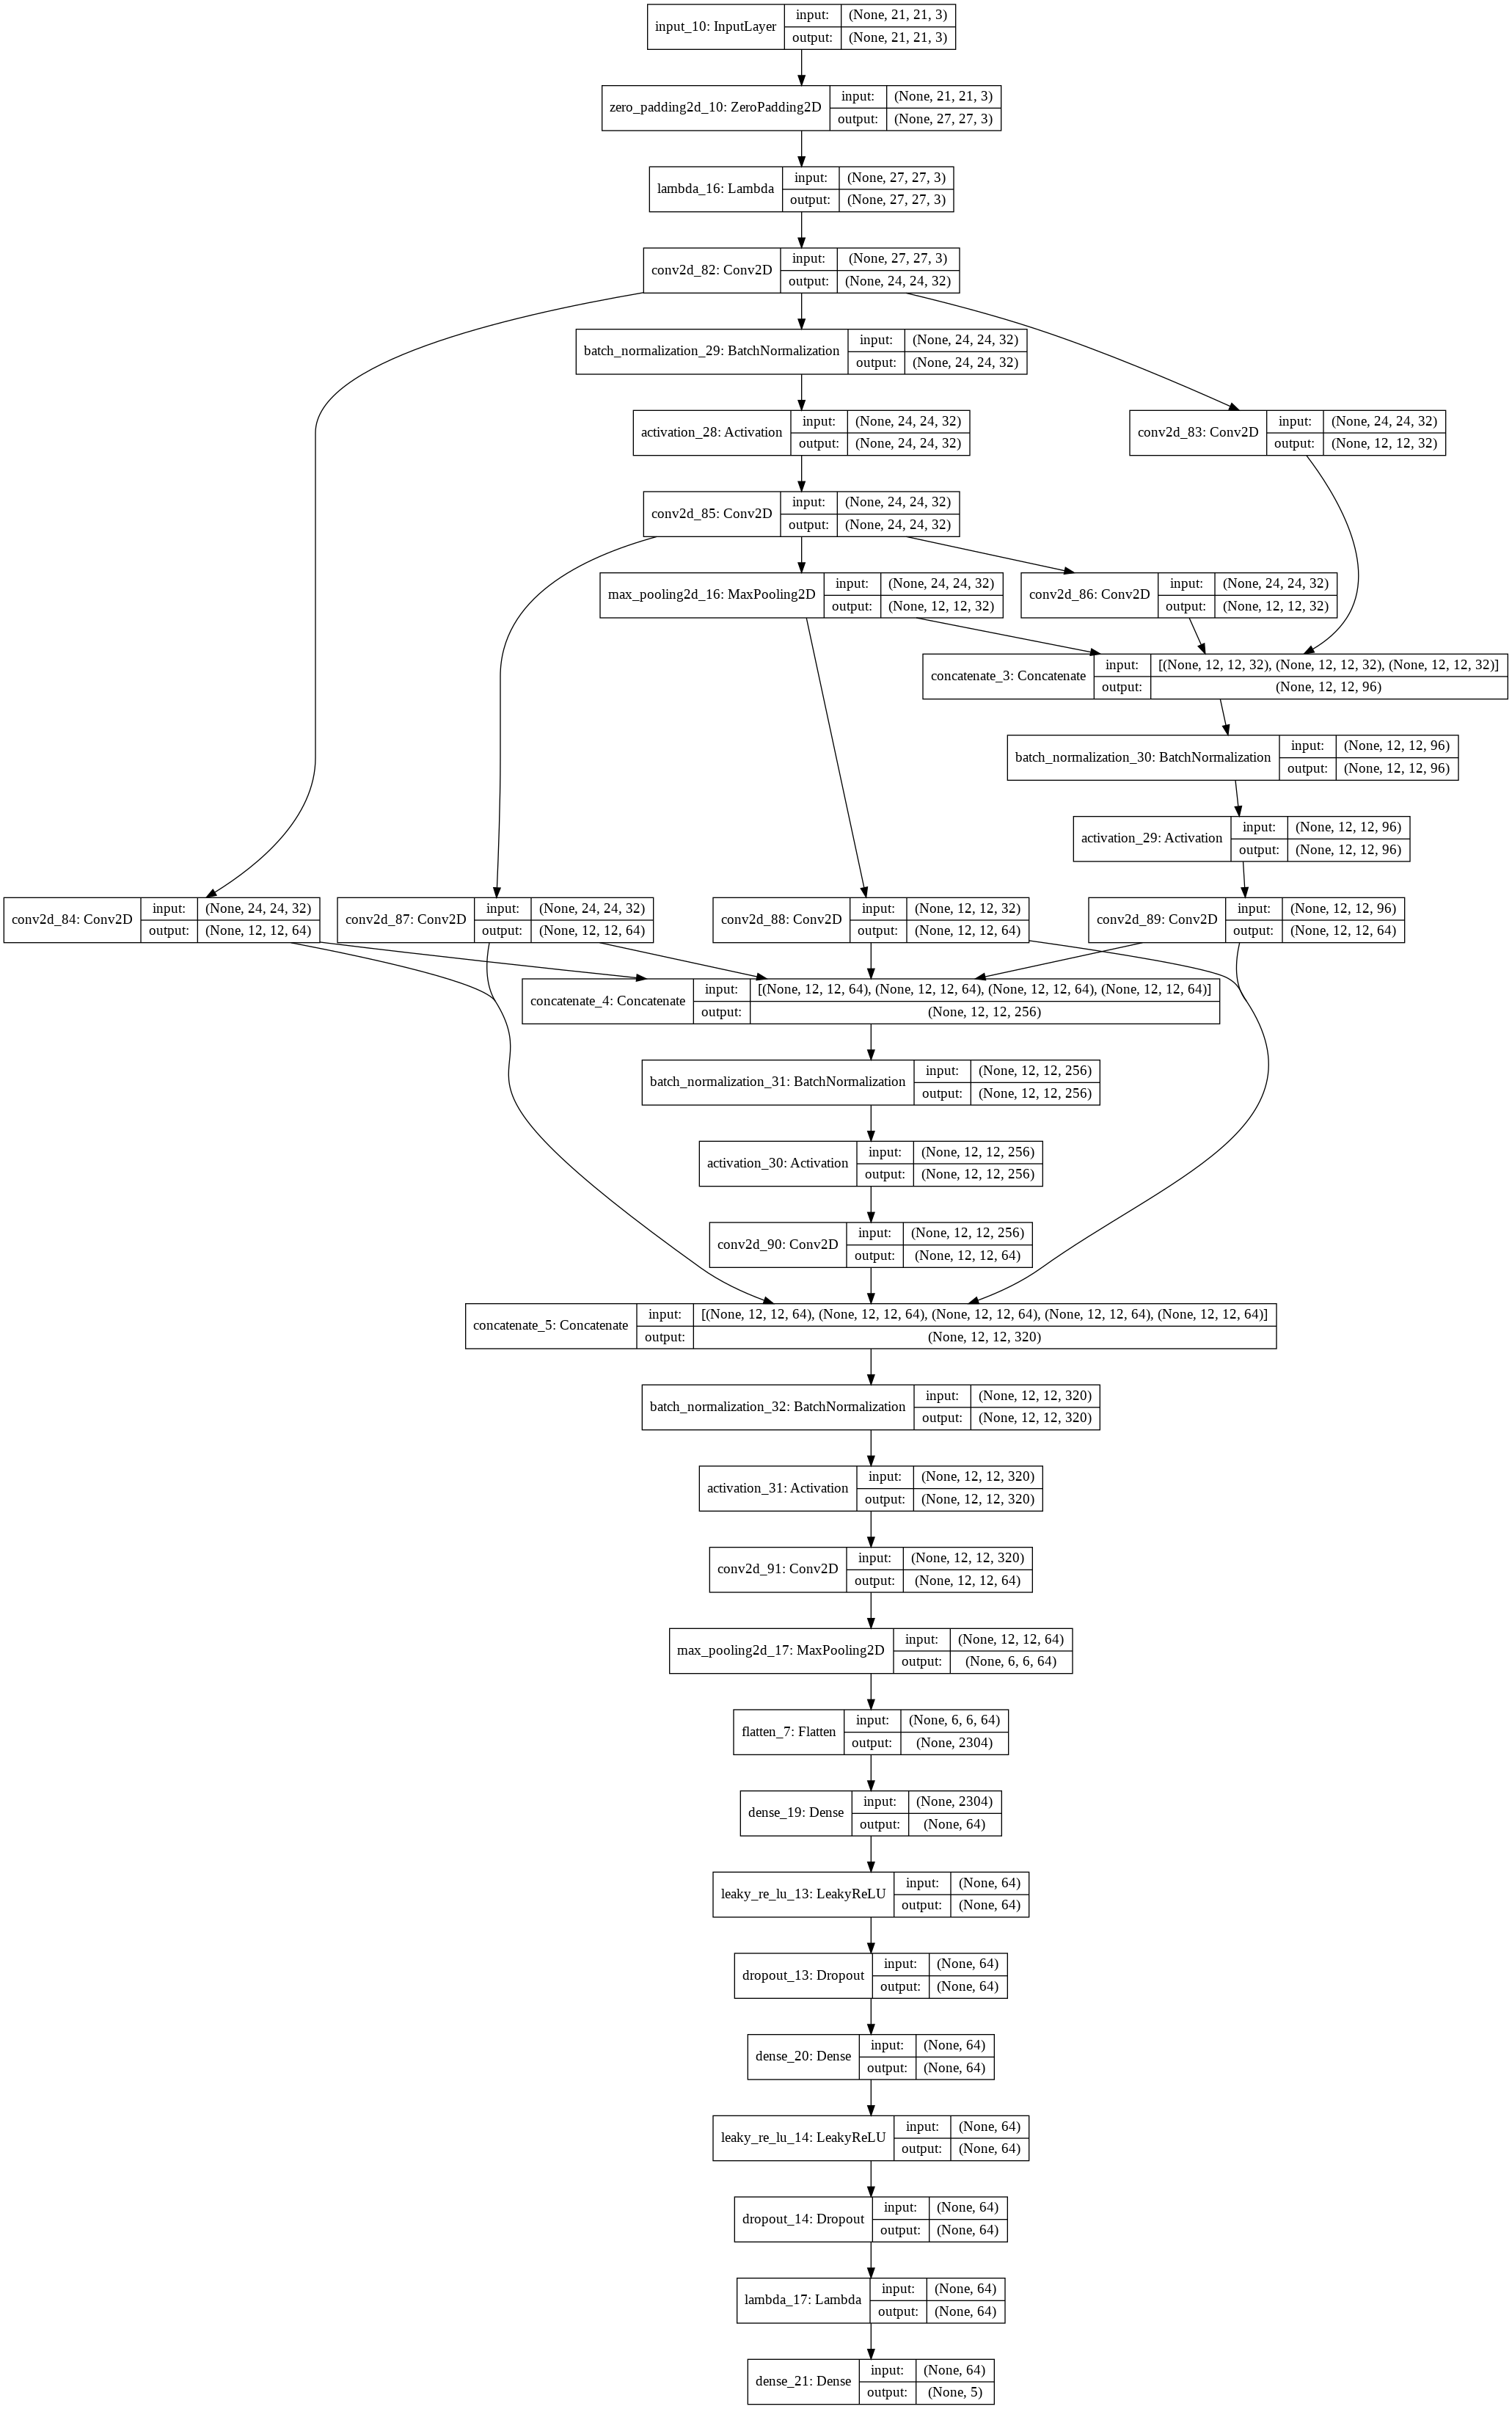

In [234]:
time_i = time()

x0 = Input(shape=input_shape) 

x1 = ZeroPadding2D(padding=(3, 3), input_shape=input_shape)(x0)
if rotations:
  x1 = Lambda(rotate_input)(x1)
# antes del max pool conv 1x1 stride 2
# x2 = Conv_Block(x1, filters=32, kernel_size=(4,4), padding='valid')
x2=  Conv2D(32, kernel_size=(4, 4), activation = 'relu', padding = 'valid', strides=(1, 1))(x1)
y2=  Conv2D(32, kernel_size=(1, 1), activation = None, strides=(2, 2))(x2) # retroalimentar
z2=  Conv2D(64, kernel_size=(1, 1), activation = None, strides=(2, 2))(x2) # retroalimentar
x3 = Conv_Block(x2, filters=32)
y3 = Conv2D(32, kernel_size=(1, 1), activation = None, strides=(2, 2))(x3) # retroalimentar
z3 = Conv2D(64, kernel_size=(1, 1), activation = None, strides=(2, 2))(x3) # retroalimentar
x4 = MaxPooling2D(pool_size=(2, 2), strides = 2)(x3)
# if dense_concat:
#   y = K.concatenate([cosas], axis=3)
# else:
#   y = Add()([X, Y])
#y = x4
z4 = Conv2D(64, kernel_size=(1, 1), activation = None, padding = 'same', strides=(1, 1))(x4) # retroalimentar
if dense_concat:
  y = Concatenate()([y2, y3, x4]) # , axis=3)
else:
  y = Add()([y2, y3, x4])
x5 = Conv_Block(y, filters=64)
if dense_concat:
  y = Concatenate()([z2, z3, z4, x5]) #, axis=3)
else:
  y = Add()([z2, z3, z4, x5])
x6 = Conv_Block(y, filters=64)
if dense_concat:
  y = Concatenate()([z2, z3, z4, x5, x6]) # , axis=3)
else:
  y = Add()([z2, z3, z4, x5, x6])
x7 = Conv_Block(y, filters=64)
x8 = MaxPooling2D(pool_size=(2, 2), strides = 2)(x7)
x9 = Flatten()(x8)
x10 = Dense(64)(x9)
x11 = LeakyReLU()(x10) # LeakyReLU
x12 = Dropout(0.5)(x11) # Se agrega la tecnica de Dropout para abordar el overfitting.
x13 = Dense(64)(x12)
x14 = LeakyReLU()(x13)
x15 = Dropout(0.5)(x14)
if rotations:
  x15 = Lambda(CAP)(x15) # Capa Cyclic Average Pooling
x16 = Dense(num_classes, activation='softmax')(x15)

model = Model(inputs=x0, outputs=x16)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy']) # Con este coomando se configura el modelo para el entrenamiento.

plot_model(model, show_shapes = True, show_layer_names = True,
           to_file='model.png') # , expand_nested = True)

In [0]:
#model.save_weights('model_0.h5')

## EarlyStopping

In [0]:
"Early Stopping"
es = EarlyStopping(monitor='val_acc', mode='auto', verbose=1, patience=5, restore_best_weights= True)

## Entrenamiento

In [236]:
print(np.shape(x_val))
print(np.shape(x_train))

print(np.shape(y_val))
print(np.shape(y_train))

(250, 21, 21, 3)
(48485, 21, 21, 3)
(250, 5)
(48485, 5)


In [0]:
# val_frac = len(x_val)/(len(x_train) + len(x_val))
# print('Fraccion de muestras a usar como validacio0n:', val_frac)

Train on 48485 samples, validate on 250 samples
Epoch 1/12
48485/48485 [==============================] - 28s 573us/step - loss: 0.5457 - acc: 0.8096 - val_loss: 0.4071 - val_acc: 0.8840
Epoch 2/12
48485/48485 [==============================] - 24s 486us/step - loss: 0.3238 - acc: 0.8898 - val_loss: 0.4003 - val_acc: 0.9080
Epoch 3/12
48485/48485 [==============================] - 24s 488us/step - loss: 0.2538 - acc: 0.9113 - val_loss: 0.4722 - val_acc: 0.8960
Epoch 4/12
48485/48485 [==============================] - 24s 488us/step - loss: 0.2111 - acc: 0.9284 - val_loss: 0.5621 - val_acc: 0.8920
Epoch 5/12
48485/48485 [==============================] - 24s 487us/step - loss: 0.1754 - acc: 0.9383 - val_loss: 0.7229 - val_acc: 0.8560
Epoch 6/12
48485/48485 [==============================] - 24s 487us/step - loss: 0.1660 - acc: 0.9409 - val_loss: 0.6823 - val_acc: 0.8800
Epoch 7/12
48485/48485 [==============================] - 24s 486us/step - loss: 0.1478 - acc: 0.9480 - val_loss: 0.70

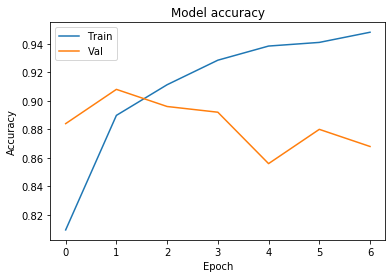

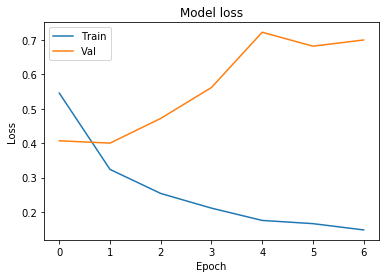

In [238]:
# Entrenamiento del modelo

# x_total = np.concatenate((x_train, x_val))
# y_total = np.concatenate((y_train, y_val))


#model_train = model.fit(x_total, y_total,

"Guardar pesos originales"
#model.save_weights('model.h5') # guardar pesos iniciales para luego reutilizarlos

#iteraciones = 10
#acc_mean = np.zeros(iteraciones)

"estas 10 iteraciones son en conjunto de test"
"podria definir una funcion que cree un arreglo de redes y que itere N veces"
"y una funcion que arme la red"

#model.load_weights('model_0.h5')
    #model.load_weights('model.h5') # reinicia siempre con los mismos parámetros
    #model.reset_states
model_train = model.fit(x_train, y_train,
                        batch_size=batch_size, 
                        epochs=epochs, verbose=1,
                        shuffle = True,#  validation_split=val_frac) #,# callbacks = [tbCallBack],
                        validation_data=(x_val, y_val),
                        callbacks = [es]) 
                #validation_steps = 5) # Comando para entrenar el modelo.
model_train
score = model.evaluate(x_val, y_val, verbose=0) # Con este comando se obtiene el valor de perdida y de las metricas en el modo de prueba.    
time_f = time()
time_execution = time_f - time_i # Con este comando se obtiene el valor de perdida y de las metricas en el modo de prueba.
print('Valid loss:', score[0]) # Se imprime la perdida para la prueba realizada.
print('Valid accuracy:', score[1]) # Se imprimre el accuracy para la prueba realizada.
#acc_mean[i] = score[1]
print('Tiempo de entrenamiento ' + str(time_execution) + ' segundos')

plt.plot(model_train.history['acc'])
plt.plot(model_train.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_train.history['loss'])
plt.plot(model_train.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Hay que ponerle un Early Stopping a estoooo 

In [239]:
print(np.shape(y_test))

(250, 5)


## Matriz de confusión

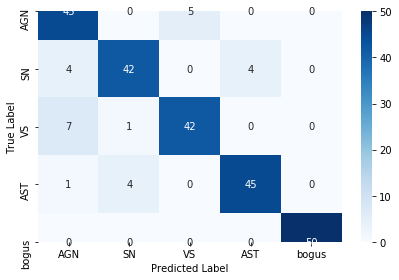

Numero de parametros:  5503852
250/250 [==============================] - 0s 231us/step
Acc val:  0.9079999976158142
250/250 [==============================] - 0s 226us/step
Acc test:  0.8960000004768371


In [240]:
scnn_pred = model.predict(x_test, batch_size=batch_size, verbose=0)  # labels predichos en one hot encoding
scnn_predicted = np.argmax(scnn_pred, axis=1)  # convertir de one hot encoding a enteros

#Creamos la matriz de confusión
scnn_cm = confusion_matrix(np.argmax(y_test, axis=1), scnn_predicted) # matriz de confusion

# Visualizamos la matriz de confusión
scnn_df_cm = pd.DataFrame(scnn_cm, range(5), range(5)) 
scnn_df_cm = scnn_df_cm.rename(index=clases, columns=clases)
#plt.figure(figsize = (20,14))  
#figure = plt.figure(figsize=(8, 8))
#sn.set(font_scale=1.) #for label size  
#sn.heatmap(scnn_df_cm, cmap = "YlGnBu", annot=True, annot_kws={"size": 30}) #, "weight": "bold"}) # font size 
#plt.savefig('Matrix_Confusion_1_proyecto.png')
sn.heatmap(scnn_df_cm, annot=True, cmap=plt.cm.Blues, fmt="d") # annot_kws={"size": 10}) #, "weight": "bold"})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('Matrix_Confusion_0.png')
plt.show()

"Fila ground truth, columna prediccion??"

Y1 = model_train.history['acc']
Y2 =  model_train.history['val_acc']
X = range(1,13)

"Ctrl + shift + 7: comment section"

# plt.plot(X,Y1,'g')
# plt.plot(X,Y2,'r')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Train Accuracy y Valid Accuracy')
# plt.legend(['Entrenamiento','Validación'])
# plt.grid(True)
# plt.savefig('Train_and_Valid_proyecto.png')
# plt.show()

x = range(1,13)
list(x)


# Comando para la obtención de la cantidad de parámetros de las redes utilizadas.
Parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])

print("Numero de parametros: ", int(Parameters))

#print("Acc promedio " + str(iteraciones) + " iteraciones: " + str(np.mean(acc_mean)) )

score_val = model.evaluate(x_val, y_val, verbose=1)
print('Acc val: ', score_val[1])
score_test = model.evaluate(x_test, y_test, verbose=1)
print('Acc test: ', score_test[1])

## Mostrar imágenes mal clasificadas

label pred: AGN, label real: SN


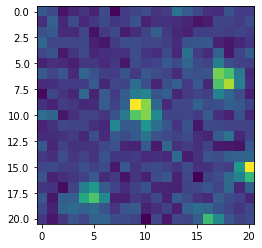

label pred: SN, label real: AST


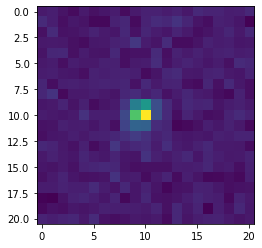

label pred: VS, label real: AGN


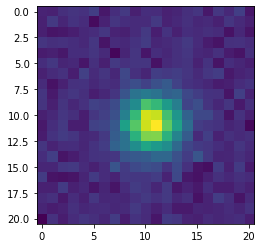

label pred: AGN, label real: VS


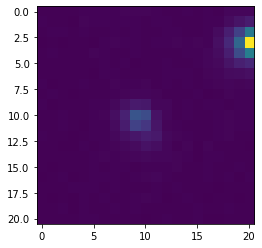

label pred: AST, label real: SN


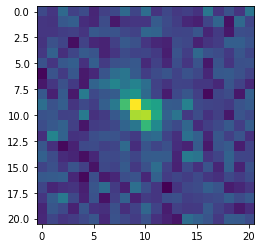

label pred: SN, label real: AST


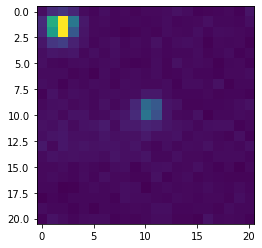

label pred: AGN, label real: VS


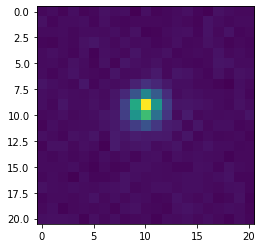

label pred: VS, label real: AGN


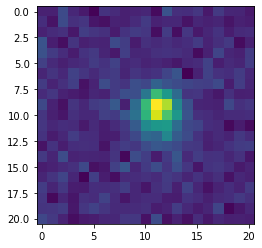

In [241]:
#print(y_test)
num_test = np.argmax(y_test, axis=1) # labels reales de conjunto test
#print(num_test)
"scnn_predicted indices predichos"

def print_different(data_pred, data_test, images, N=2):
  # N indica cuantos ejemplos errones se muestran por cada clase
  counter = np.zeros(5) # contador de clasificaciones erroneas por clase

  for k in range(len(data_pred)):

    if data_pred[k] != data_test[k]:
      counter[int(data_test[k])] += 1
      #print(counter)
      if counter[int(data_test[k])] > N:
        pass
      else:
        plt.figure()
        print('label pred: '+ clases[data_pred[k]]+ ', label real: ' + clases[data_test[k]])
        plt.clf() # clear current figure
        plt.imshow(images[k, :, :, 0], interpolation='nearest') # ,cmap=plt.cm.Blues
        plt.show()

print_different(scnn_predicted,num_test,x_test, 2)


In [0]:
# del model